In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import os
import pickle
import importlib
import detect_bursts
importlib.reload(detect_bursts)
import copy
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score
from sklearn.model_selection import GridSearchCV,train_test_split

from collections import defaultdict

Derive Nine Parameters

In [2]:
#within-burst number of spikes
def withinBurstNumSpikes(burstIndicator):
    num = len(np.where(burstIndicator == 1)[0])
    percentage = num/burstIndicator.shape[0]
    return num,percentage

#burst duration and inter-burst interval
def durations(timestamps,finalBurstRanges):
    burst = timestamps[finalBurstRanges[0][1]] - timestamps[finalBurstRanges[0][0]]
    #here we assume interBurst doesn't include the start-first-burst interval or the last-burst-end interval
    interBurstSt = finalBurstRanges[0][1]
    interBurst = 0

    maxSpikingFreq = (finalBurstRanges[0][1] - finalBurstRanges[0][0] + 1)/burst

    #tuple representing current burst
    for tup in finalBurstRanges[1:]:
        burstInc = timestamps[tup[1]] - timestamps[tup[0]]
        burst += burstInc
        interBurst += timestamps[tup[0]] - timestamps[interBurstSt]
        interBurstSt = tup[1]

        #count spikes within current burst
        curSpikingFreq = (tup[1]-tup[0]+1)/burstInc
        if maxSpikingFreq < curSpikingFreq:
            maxSpikingFreq = curSpikingFreq

    burst /= 1000
    interBurst /= 1000
    maxSpikingFreq *= 1000
    return burst,interBurst,maxSpikingFreq

#within-burst spiking frequency
def meanSpikingFreq(num,duration):
    return num/duration * 1000

#surprise values
def surpriseEval(finalBurstSurprises):
    meanSurprise = np.mean(finalBurstSurprises)
    maxSurprise = np.max(finalBurstSurprises)
    return meanSurprise,maxSurprise

#mean burst frequency
def meanBurstFreq(finalNumBursts,totalTime):
    meanburstFreq = finalNumBursts/totalTime
    meanburstFreq = meanburstFreq* 1000
    return meanburstFreq

#render 9 parameters for each sample (1 trial of 1 neuron)
def renderParams(timestamps,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime):
    withinBurstSpikeNum,withinBurstSpikePercentage = withinBurstNumSpikes(burstIndicator)
    duration,interBurst,maxSpikingFreq = durations(timestamps,finalBurstRanges)
    meanSpikingFreq = withinBurstSpikeNum/duration
    meanSurprise,maxSurprise = surpriseEval(finalBurstSurprises)
    meanburstFreq = meanBurstFreq(finalNumBursts,totalTime)
    return [duration,meanSpikingFreq,maxSpikingFreq,withinBurstSpikeNum,\
            interBurst,withinBurstSpikePercentage,meanburstFreq,meanSurprise,maxSurprise]


def formulateDataset(totalDf,totalName = None,totalLabel = None):
    sampleDataset = []
    nameRes = []
    labelRes = []

    no_burst_sampleDataset = []
    no_burst_nameRes = []
    no_burst_labelRes = []

    if totalName is None:
        totalName = ['']*(totalDf.shape[0])

    if totalLabel is None:
        totalLabel = [0]*(totalDf.shape[0])
        
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2)
        
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(\
                lInput,finalBurstRanges,finalBurstSurprises,\
                    burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
            labelRes.append(totalLabel[index])

        else:
            #no burst in current list of timestamps
            no_burst_sampleDataset.append(dfRow)
            no_burst_nameRes.append(totalName[index])
            no_burst_labelRes.append(totalLabel[index])

    return sampleDataset,nameRes,labelRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes



In [3]:
with open('supervised_learning/spike_df.pkl', 'rb') as f:
    spike_df = pickle.load(f)

#replace 'PN' with 1 and 'LN' with 0
spike_df['label'] = spike_df['label'].replace(['PN','LN'],[1,0])

total_name = spike_df['mothname']
total_label = spike_df['label']
total_timestamps = spike_df['timestamps']

#formulate dataset
sampleDataset,nameRes,labelRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes\
          = formulateDataset(total_timestamps,total_name,total_label)

#pickle save sampleDataset
with open('supervised_learning/derived_burst_parameters.pkl', 'wb') as f:
    pickle.dump((sampleDataset,nameRes,labelRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes), f)

In [4]:
print(total_timestamps[0])

[ 105.75  450.47  596.6   937.5  1173.06 1379.   1718.12 1941.52 2031.74
 2177.87 2342.84 2498.44 2595.11 2595.21 2745.45 2818.81 3025.4  3322.6
 3572.89 3682.36 4086.35 4428.85 4861.91 4951.54]


In [5]:
#supervised learning
with open('supervised_learning/derived_burst_parameters.pkl', 'rb') as f:
    sampleDataset,nameRes,labelRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes = pickle.load(f)

In [6]:
print(np.array(sampleDataset).shape)

print(len(no_burst_sampleDataset))

(29, 9)
18


In [5]:
#supervised -- save data into csv file
def supervised_saveData(dataset,nameRes,labelRes,save_path = "supervised_learning/nine_burst_parameters.csv"):
    df = pd.DataFrame(dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    df['label'] = labelRes
    
    #save parameters into csv file
    df.to_csv(save_path, index=False)
    return df

df = supervised_saveData(sampleDataset,nameRes,labelRes)

In [7]:
lstColumnNames = list(df.columns[:-2])
display(df)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,0.40261,12.418966,12.418966,5,0.00000,0.217391,0.201957,1.192730,1.192730,060324124,0
1,0.26911,59.455241,59.455241,16,0.00000,0.092486,0.200605,1.257588,1.257588,071031002,0
2,0.02979,100.704935,100.704935,3,0.00000,0.010563,0.200198,3.615758,3.615758,071031005,0
3,0.41987,7.145069,7.145069,3,0.00000,0.176471,0.205084,1.146890,1.146890,060223175,1
4,1.18069,6.775699,12.555716,8,1.20391,0.250000,0.404303,1.373569,1.613699,060223174,1
5,1.00932,9.907661,25.980774,10,3.19860,0.384615,0.624064,1.050495,1.388560,060223176,1
6,0.76495,9.150925,9.671881,7,1.57373,0.212121,0.401039,1.093744,1.396758,060223173,1
7,0.90932,13.196674,23.822759,12,1.53128,0.387097,0.800096,0.903848,1.057262,060223172,1
8,0.26549,56.499303,56.499303,15,0.00000,0.092593,0.201020,1.311335,1.311335,071016215,1
9,0.28201,56.735577,62.214849,16,0.92125,0.104575,0.400860,0.935947,1.012572,071016216,1


In [8]:
#define scoring function for later grid search based upon\
    #  AUC, F1 score, and accuracy as evaluation metrics
def evalCriterion(classifier,X,y):
    #prediction labels
    y = np.array(y)
    yPred = classifier.predict(X)
    #print("yPred: ",yPred,"\n","y: ",y)

    #accuracy
    accu = accuracy_score(y,yPred)

    #F1
    f1 = f1_score(y,yPred)

    #AUC
    #we directly use the labels to compute the AUC scores \
    # (only considering threshold 0.5 while plotting the ROC curve)
    #with the same metric for all classifiers, \
    # we can compare the AUC scores to see which classifier is better
    yPred = classifier.predict_proba(X)[:,1]
    auc = roc_auc_score(y,yPred)
    
    return {'auc':auc,'F1':f1,'accu':accu}

#implement the general function which tunes the parameter of a classifier and 
#perform N-fold cross validation to evaluate the performance of the classifier
#with metrics including AUC, F1 score, and accuracy
def tunaClassifier(XTrain,yTrain,XTest,yTest,NFold,estimatorFunc,params):
    #use the GridSearchCV method to stratify the data into N folds
    #and perform training with cross validation

    #sort classifier performance by AUC, F1 score, and accuracy scores
    gridSearchClassifier = GridSearchCV(\
        estimatorFunc,param_grid=params,cv=NFold,\
            scoring=evalCriterion,refit = 'auc',n_jobs=1)
    gridSearchClassifier.fit(XTrain,yTrain)

    #return average evaluation metrics for each combination of parameters
    rs = gridSearchClassifier.cv_results_
    display(rs)
    meanValidationAUC = rs['mean_test_auc']
    meanValidationF1 = rs['mean_test_F1']
    meanValidationAccu = rs['mean_test_accu']
    bestParams = gridSearchClassifier.best_params_

    #display the optimal parameter combination
    print(f'The optimal parameter combination is: {bestParams}')

    #train the classifier with the optimal parameter combination on full training set
    dclf = gridSearchClassifier.best_estimator_
    dclf.fit(XTrain,yTrain)

    #test the classifier on the test set
    yTestPred = dclf.predict(XTest)
    #yPredProba = dclf.predict_proba(XTest)[:,1]

    #display the performance of the classifier on the test set
    testAUC = roc_auc_score(yTest,yTestPred)
    testF1 = f1_score(yTest,yTestPred)
    testAccu = accuracy_score(yTest,yTestPred)

    return meanValidationAUC,meanValidationF1,meanValidationAccu,\
        yTestPred,testAUC,testF1,testAccu,\
        dclf,bestParams

In [59]:
def reductionClassification(sampleDF,lstColumnNames,reductionFunc,reductionParams,\
                            classifyingFunc,classifyingParamsDict,\
                                shuffleRandomState,isShuffle = True):
    #setup unsupervised classification training
    #shuffle sample dataset
    if isShuffle:
        sampleDF = shuffle(sampleDF,random_state=shuffleRandomState)

    #normalization
    sample = preprocessing.normalize(sampleDF.loc[:,lstColumnNames])

    #fit clustering model
    _,_,_,pred_label,\
        pred_AUC,pred_F1,pred_accu,\
            dclf,_ = tunaClassifier(sample,sampleDF['label'],\
                                        sample,sampleDF['label'],\
                                            3,classifyingFunc,classifyingParamsDict)
    
    #dimensionality reduction
    reducedSample = reductionFunc(**reductionParams).fit_transform(sample)

    #put 'Subject' and 'Label' back to reducedSample and form new dataframe
    reducedSampleDF = pd.DataFrame(reducedSample,columns=['PC1','PC2'])
    reducedSampleDF['Subject'] = copy.deepcopy(sampleDF['Subject'])
    reducedSampleDF['label'] = copy.deepcopy(sampleDF['label'])
    reducedSampleDF['pred_label'] = copy.deepcopy(pred_label)

    #give pred_label column also to sampleDF before dimensionality reduction
    sampleDF['pred_label'] = copy.deepcopy(pred_label)
    

    return sampleDF,reducedSampleDF,pred_AUC,pred_F1,pred_accu,dclf

#supervised

#TSNE
TSNEparams = {'n_components':2,'random_state':42}

#KPCA
KPCAparams = {'n_components':2,'kernel':'linear'}

#Logistic Regression Classifier
LRparams = {'penalty':['l2','elasticnet',None],\
            'solver':['lbfgs','liblinear',\
                'newton-cg','newton-cholesky',\
                    'sag','saga'],\
                        'max_iter':[1000],'random_state':[42],\
                            'class_weight':[{0:1,1:7}]}

#SGD Classifier
SGDparams = {'alpha':[0.0001,0.001,0.01,0.1,1],\
             'loss':['log','modified_huber','squared_hinge',\
                     'perceptron','squared_loss','huber','epsilon_insensitive',\
                         'squared_epsilon_insensitive'],\
                             'penalty':['l1','l2','elasticnet'],\
                                         'random_state':[42],\
                                             'class_weight':[{0:1,1:7}]}
#Result
DF,reducedSampleDF,pred_AUC,pred_F1,pred_accu,dclf = reductionClassification(df,lstColumnNames,KernelPCA,KPCAparams,\
                                             LogisticRegression(),LRparams,\
                                                shuffleRandomState = 42,isShuffle = True)

{'mean_fit_time': array([0.01437314, 0.00244006, 0.00865261, 0.00053088, 0.00274301,
        0.00204174, 0.00058818, 0.00050974, 0.0003713 , 0.00032028,
        0.00031296, 0.00048224, 0.00039228, 0.00033768, 0.00029588,
        0.00027355, 0.00026298, 0.00026202]),
 'std_fit_time': array([1.47566109e-02, 1.95041539e-03, 3.18910141e-03, 4.82573706e-05,
        1.16947754e-03, 2.10182472e-04, 1.39053979e-04, 6.63149467e-05,
        1.10708461e-04, 2.14888499e-05, 1.83074146e-05, 1.17971404e-04,
        1.08530891e-04, 5.02531218e-05, 2.65284644e-05, 1.17453251e-05,
        7.84248552e-06, 1.28362815e-05]),
 'mean_score_time': array([0.00276311, 0.00248528, 0.00311486, 0.        , 0.00294828,
        0.00424019, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 'std_score_time': array([0.00073318, 0.00026475, 0.00021065, 0.        , 0.00029617,
        0.00075972, 0.        , 

The optimal parameter combination is: {'class_weight': {0: 1, 1: 7}, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}


Statistics Result Analysis

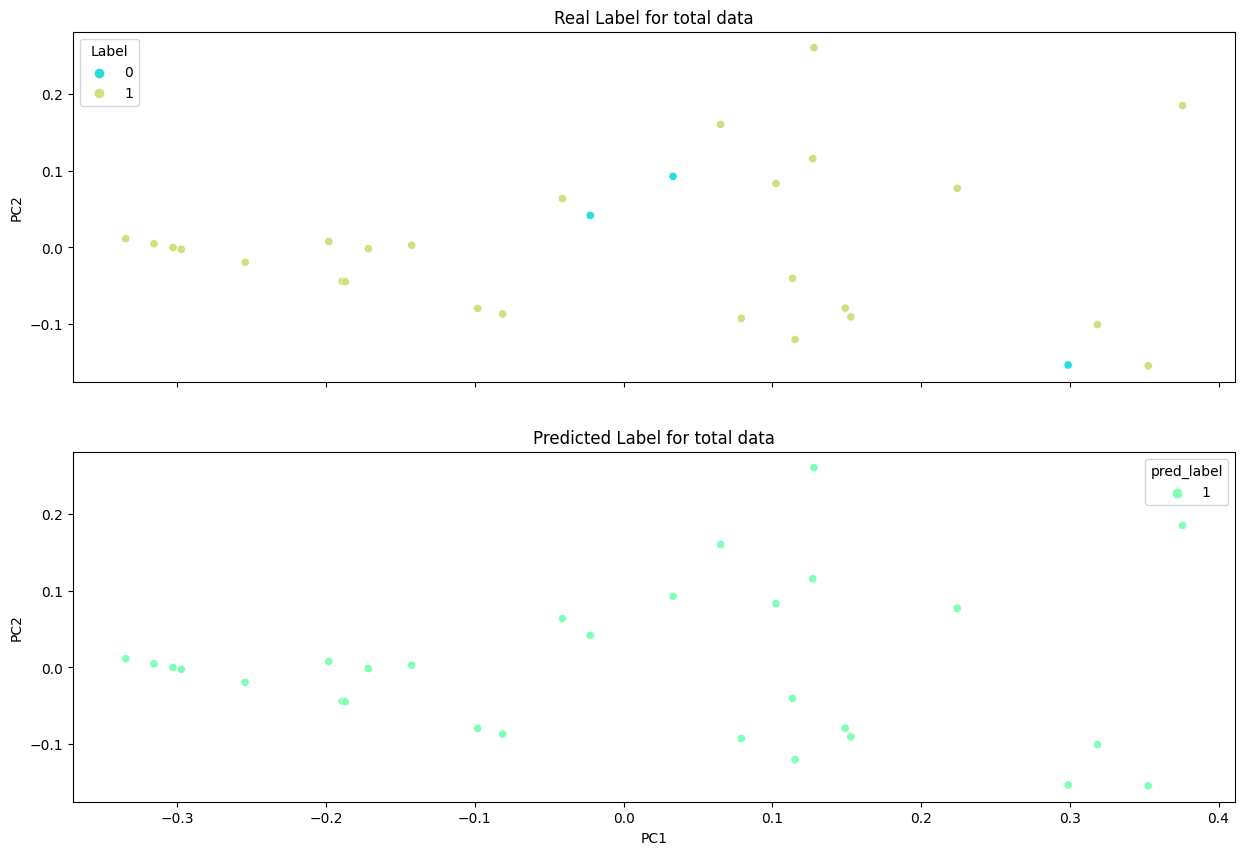

In [60]:
def classificationResultPlot(reducedSampleDF,\
                             file_name = 'Logistic_Regression.jpg'):
    
    fig,axs = plt.subplots(2,1,sharex = True,sharey = True,figsize=(15,10))

    #plotting according to real label, color map should be matplotlib colormap
    sns.scatterplot(data = reducedSampleDF,\
                    x = 'PC1',y = 'PC2',\
                    hue = "Label", palette = 'rainbow',\
                        ax = axs[0])

    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[0].set_title('Real Label for total data')

    #plotting according to predicted label
    sns.scatterplot(data = reducedSampleDF,\
                    x = 'PC1',y = 'PC2',\
                    hue = "pred_label", palette = 'rainbow',\
                        ax = axs[1])
    
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC2')
    axs[1].set_title('Predicted Label for total data')

    #save figures
    fig.savefig(file_name)

    #axs[0].legend()
    #axs[1].legend()
    plt.show()


classificationResultPlot(reducedSampleDF)

In [61]:
#give number of datapoints in each cluster
def numberDatapointsInClusters(DF):
    #group by label
    groupedDF = DF.groupby('pred_label')
    #count number of datapoints in each cluster
    countDF = groupedDF.count()
    return countDF

print(numberDatapointsInClusters(DF))

            burst duration  within-burst spiking freq  \
pred_label                                              
1                       29                         29   

            within-burst max spiking freq  within-burst number of spikes  \
pred_label                                                                 
1                                      29                             29   

            inter-burst interval  percentage of burst spikes  burst frequency  \
pred_label                                                                      
1                             29                          29               29   

            mean surprise  max surprise  Subject  Label  
pred_label                                               
1                      29            29       29     29  


In [10]:
def histoResults(DF,lstColumnNames,plotFunc,plotParams,saveFileName = 'histograms.jpg',barplot = False):
    #3x3 subplots
    #fig,ax = plt.subplots(9,1,figsize=(15,15))
    fig = plt.figure(figsize=(15,15))
    #sns plot with hue of each of the nine parameters on a row for datapoints in each cluster
    for j in range(9):
        #use "y = " for barplot, "x = " otherwise
        #figure into the jth subplot
        fig.add_subplot(3,3,j+1)
        if barplot:
            plotFunc(data=DF,y=lstColumnNames[j],**plotParams)
        else:
            plotFunc(data=DF,x=lstColumnNames[j],**plotParams)

        #ax[j].set_title(f'cluster {lstColumnNames[j]}')

    plt.show()
    fig.savefig(saveFileName)
    return

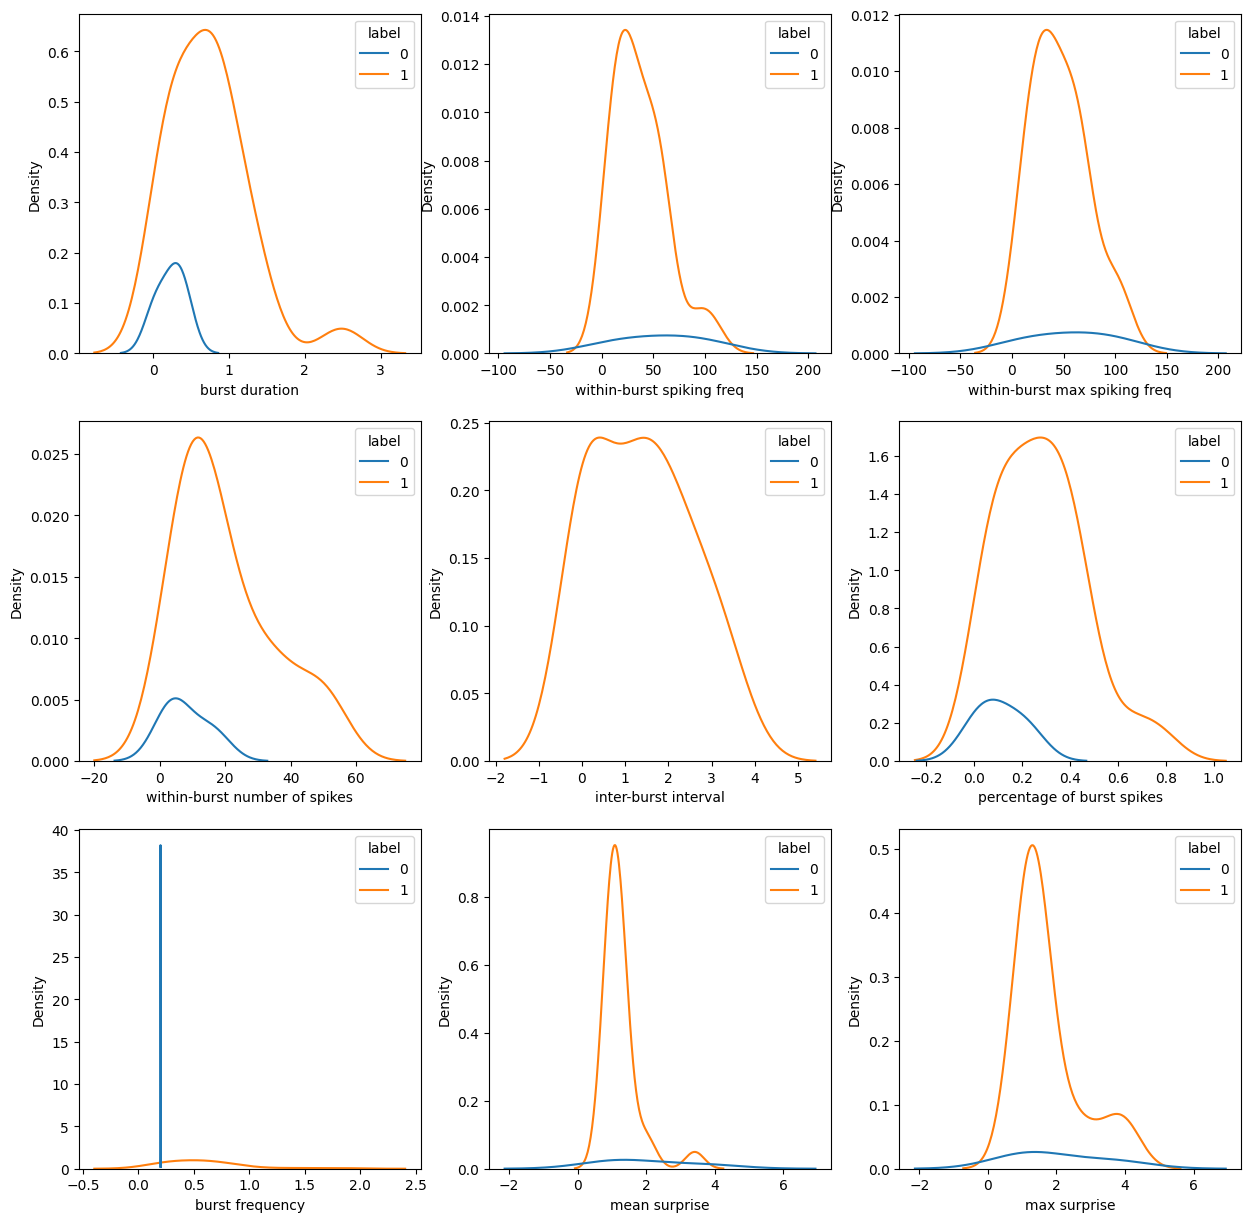

In [11]:
histoResults(df,lstColumnNames,sns.kdeplot,{'hue':'label'},'supervised_learning/real_label_kdeplot.jpg')

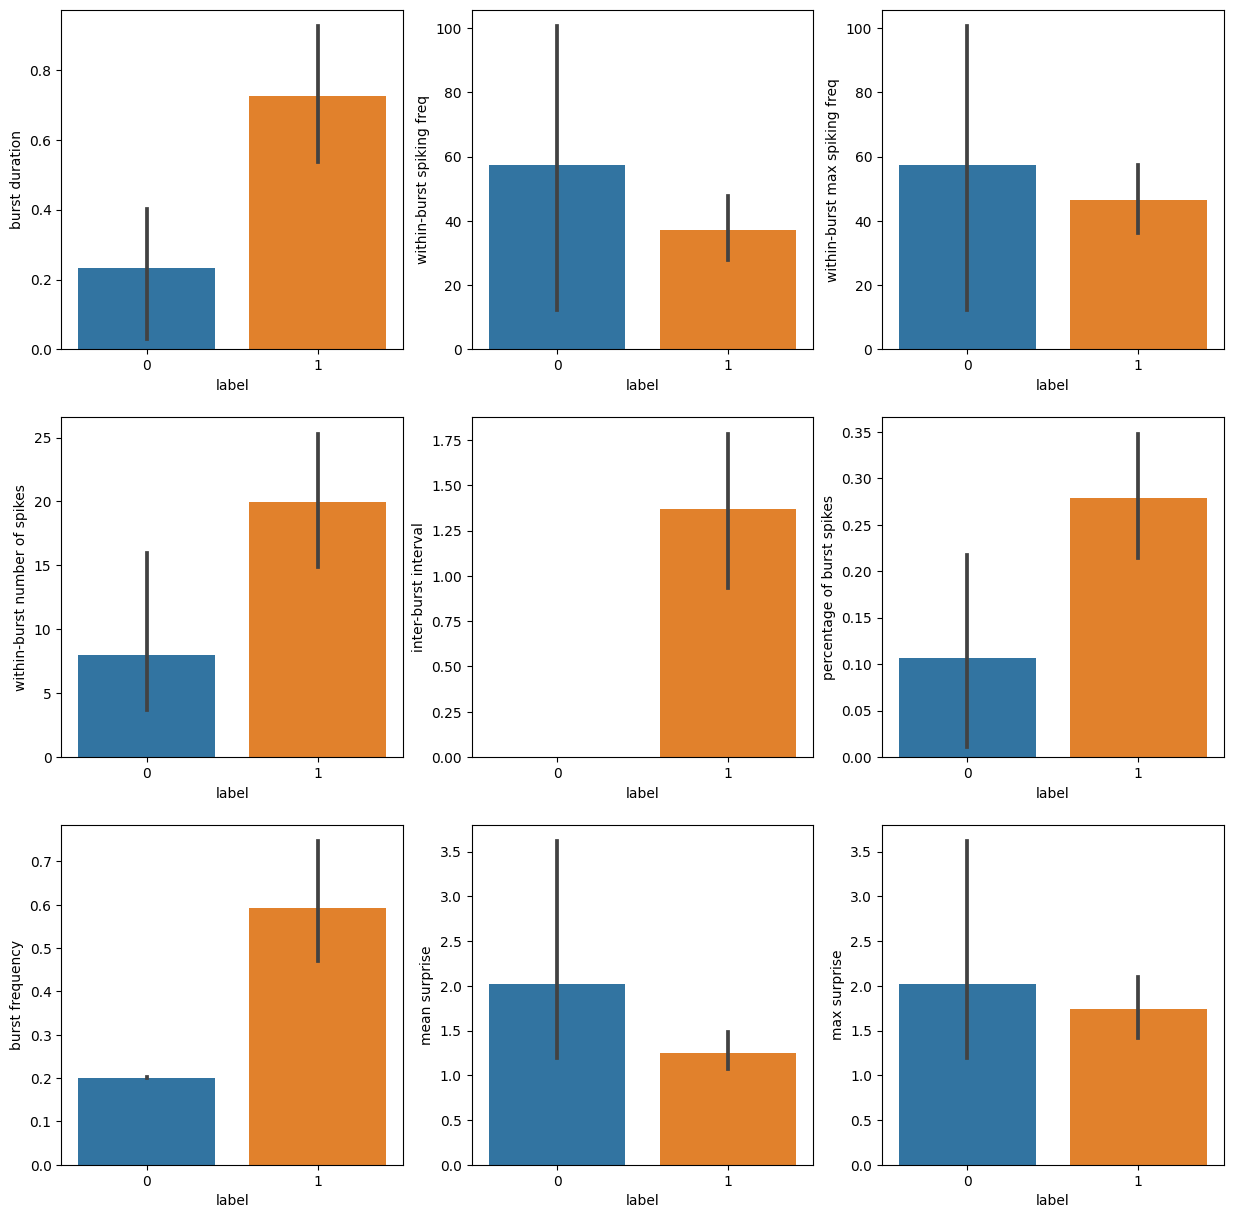

In [12]:
#barplot w.r.t. real label data
histoResults(df,lstColumnNames,
             sns.barplot,{'x':'label'},'supervised_learning/labeled_data_real_barplot.jpg',barplot=True)